In [80]:
from scipy import interpolate
import pandas as pd
PATH = "C:\\Users\\takut\\OneDrive - 東京工業大学大西研究室\\lab_document\\summation_of_cylinder"
df_ReD_CD = pd.read_csv(PATH + "\\CD_ReD_exmp_dataset_redo.csv", names=['ReD', 'CD'])
ReD_exp_data = df_ReD_CD['ReD'].to_numpy()
CD_exp_data = df_ReD_CD['CD'].to_numpy()

f = interpolate.interp1d(ReD_exp_data, CD_exp_data, 'linear')

In [81]:
import math
import pickle

def CD_cylinder(ux, D, theta3, nu = 15.48e-6):
    ReD = ux * D / nu
    '''
    if 15 <= ReD < 268:
        cd_basic = 5.7844 * ReD ** (-0.316)
    elif 268 <= ReD < 1072:
        cd_basic = 1.0399 * ReD ** (-0.009)
    elif 1072 <= ReD < 6432:
        cd_basic = 0.94 * ReD ** (0.0057)
    elif 6432 <= ReD < 12864:
        cd_basic = 1.2797 * ReD ** (-0.03)
    '''
    if 0.116127497 <= ReD < 0.97053899:
        cd_basic = 10.5 * ReD ** (-0.757)
    elif 0.97053899 <= ReD < 11.27062635:
        cd_basic = 10.559 * ReD ** (-0.568)
    elif 11.27062635 <= ReD < 103.0355309:
        cd_basic = 5.3929 * ReD ** (-0.29)
    elif 103.0355309 <= ReD < 1061.632062:
        cd_basic = 2.8535 * ReD ** (-0.153)
    elif 1061.632062 <= ReD < 11612.74969:
        cd_basic = 0.6152 * ReD ** (0.0672)
    elif 11612.74969 <= ReD < 311534.7476:
        cd_basic = 1.9169 * ReD ** (-0.054)
    elif 311534.7476 <= ReD < 8611224.963:
        cd_basic = f(ReD)

    cd_with_angle = cd_basic * math.sin(math.pi * (90 - theta3) / 180) ** 3
    return cd_basic, cd_with_angle

In [82]:
import numpy as np
from scipy import interpolate
def CF_cylinder_linear(ux, D, theta3, nu = 15.48e-6):
    ReD_list = np.array([15, 268, 1072, 6432, 12864])
    CF_list = np.array([1.60796, 0.25461, 0.107676, 0.0351097, 0.0222011])
    li = interpolate.interp1d(ReD_list, CF_list, 'linear')
    ReD = ux * D / nu
    cf_basic = float(li(ReD))
    cf_with_angle = cf_basic * math.sin(math.pi * (90 - theta3) / 180) ** 3
    return cf_with_angle

In [83]:
def CF_cylinder_power(ux, D, theta3, nu = 15.48e-6):
    ReD = ux * D / nu
    cf_basic = 8.8507 * ReD ** (-0.632)
    cf_with_angle = cf_basic * math.sin(math.pi * (90 - theta3) / 180) ** 3
    return cf_with_angle

In [84]:
def CP_cylinder_power(ux, D, theta3, nu = 15.48e-6):
    ReD = ux * D / nu
    if 15 <= ReD < 268:
        cp_basic = -0.273 * math.log(ReD) + 3.097
    elif 268 <= ReD < 1072:
        cp_basic = 0.1267 * math.log(ReD) + 0.8615
    elif 1072 <= ReD < 6432:
        cp_basic = -0.024 * math.log(ReD) + 1.9155
    elif 6432 <= ReD < 12864:
        cp_basic = -0.012 * math.log(ReD) + 1.8073
    cp_with_angle = cp_basic * math.sin(math.pi * (90 - theta3) / 180) ** 3
    return cp_with_angle

Above is what I'm gonna make for calculation of CF on each cylinder.  
<b>The provisional procedure</b>
<ul>
<li>make the dict of CF without angles(two floors and the fitst kew is Re(velocity) the second key is the number of repetition)</li>
<li>subtract the value of this dict from the cd_basic either(CD_cylinder()[0]), then got the dict of CP</li>
<li>make the dict of CF and CP with angles(the way of taking weight into account is the same as that of CD.)</li>
</ul>

In [85]:
# perpendicular
def FD_cylinder(ux, L, D, cd, rho = 1.205):
    fd1 = 1/2 * rho * ux ** 2 * L * D * cd 
    return fd1

In [86]:
def FF_cylinder(ux, L, D, cf, rho = 1.205):
    ff = 1/2 * rho * ux ** 2 * L * D * cf
    return ff

In [87]:
def FP_cylinder(ux, L, D, cp, rho = 1.205):
    fp = 1/2 * rho * ux ** 2 * L * D * cp
    return fp

In [88]:
def CD_Tree(FD, ux, A ,rho = 1.205):
    return FD / (1/2) / rho / ux ** 2 / A

In [89]:
def CF_Tree(FF, ux, A ,rho = 1.205):
    return FF / (1/2) / rho / ux ** 2 / A

In [90]:
def CP_Tree(FP, ux, A ,rho = 1.205):
    return FP / (1/2) / rho / ux ** 2 / A

In [91]:
def total_lateral_area(Ls, Ds):
    total_lateral = 0
    for key in Ls:
        total_lateral += math.pi * Ds[key] * Ls[key] * 2 ** int(key)
    return total_lateral


In [92]:
def aspect_ratio(Ls, Ds):
    aspect_ratios = {}
    for key in Ls:
        aspect_ratios[key] = Ls[key] / Ds[key]
    return aspect_ratios

In [93]:
def main(Uxs, theta3s, Ls, Ds, A):
    FD_totals = []
    FF_totals = []
    FP_totals = []
    global CD_Trees, CF_Trees, CP_Trees
    CD_Trees = []
    CF_Trees = []
    CP_Trees = []
    for ReH in Uxs:
        ux = Uxs[ReH]
        cds = {}

        cfs = {}
        for key in theta3s:
            cds[key] = []

            cfs[key] = []
            for j in range(len(theta3s[key])):
                cd = CD_cylinder(ux, Ds[key], theta3s[key][j])[1]
                cds[key].append(cd)
                cf = CF_cylinder_power(ux, Ds[key], theta3s[key][j])
                cfs[key].append(cf)

        for key in cds:
            print(f"n:{key} cds:{cds[key]}")
        for key in cfs:
                    print(f"n:{key} cfs:{cfs[key]}")
        fds = {}

        ffs = {}
        fd_total = 0

        ff_total = 0
        for key in theta3s:
            fds[key] = []

            ffs[key] = []
            for i in range(len(theta3s[key])):
                fd = FD_cylinder(ux, Ls[key], Ds[key], cds[key][i])
                fds[key].append(fd)
                fd_total += fd
                ff = FF_cylinder(ux, Ls[key], Ds[key], cfs[key][i])
                ffs[key].append(ff)
                ff_total += ff
        fp_total = fd_total - ff_total


        for key in fds:
            print(f"n:{key} fds:{fds[key]}")
            print(f"n:{key} ffs:{ffs[key]}")
        print("----------------------------------------")
        print(f"ReH:{ReH} Summation of fd is {fd_total}")
        print(f"ReH:{ReH} Summation of ff is {ff_total}")
        print(f"ReH:{ReH} Summation of fp is {fp_total}")
        print("----------------------------------------")
        FD_totals.append(fd_total)
        FF_totals.append(ff_total)
        FP_totals.append(fp_total)
        CD = CD_Tree(fd_total, ux, A)
        CD_Trees.append(round(CD, 3))
        CF = CF_Tree(ff_total, ux, A)
        CF_Trees.append(round(CF, 3))
        CP = CP_Tree(fp_total, ux, A)
        CP_Trees.append(round(CP, 3))
    print(f"FDs:{FD_totals}")
    print(f"FFs:{FF_totals}")
    print(f"FPs:{FP_totals}")
    print(f"CD_Trees:{CD_Trees}")
    print(f"CF_Trees:{CF_Trees}")
    print(f"CP_Trees:{CP_Trees}")

In [94]:
import matplotlib.pyplot as plt
def visualization(CD_Trees, CF_Trees, CP_Trees, n):
    fig = plt.figure(figsize = (15, 8))
    fig.suptitle('Theoretical analysis of $C_D, C_F, C_P$', fontsize=24)
    ax = fig.add_subplot(111)
    x = [2500, 10000, 60000, 120000, 1200000, 2400000, 4800000, 9600000, 19200000, 38400000, 76800000]
    y1 = CD_Trees
    y2 = CF_Trees
    y3 = CP_Trees
    ax.plot(x, y1, color = 'black', marker = 'o', label = f'$C_D$ n={n}')
    #ax.plot(x, y2, color = 'blue', marker = 'o', label = f'$C_F$ n={n}')
    #ax.plot(x, y3, color = 'orange', marker = 'o', label = f'$C_P$ n={n}')
    ax.set_xscale('log')
    ax.set_xlabel('ReH', fontsize=24)
    ax.set_ylabel('$C_D$', fontsize=24)
    ax.set_xlim(1e+3, 1e+8)
    ax.set_ylim(0, 2)
    ax.legend(loc = 'best', fontsize=24)
    plt.show()


alphas : {'0': [0], '1': [19.937761203690833, 19.937761203690833], '2': [9.791075747609263, 49.52452769449419, 49.52452769449419, 9.791075747609263], '3': [14.76545595807149, 33.32644032868675, 69.42479742490801, 22.416181362070432, 22.416181362070432, 69.42479742490801, 33.32644032868675, 14.76545595807149], '4': [7.417155232467079, 18.2004764342232, 30.34737099404775, 26.510517094129575, 62.748911160542924, 47.10125698292611, 7.487133322440497, 32.01774831302921, 32.01774831302921, 7.487133322440497, 47.10125698292611, 62.748911160542924, 26.510517094129575, 30.34737099404775, 18.2004764342232, 7.417155232467079], '5': [6.161682075431288, 19.325187459883935, 2.397524045280882, 35.64956250460369, 53.47271305435132, 4.1018756218858305, 33.482113577886686, 12.7939283181808, 51.64897907154649, 49.076392207515276, 17.84138793755335, 74.24770946899987, 1.4319123490737709, 11.578093515932846, 13.405998059639284, 43.349930544391455, 43.349930544391455, 13.405998059639284, 11.578093515932846,

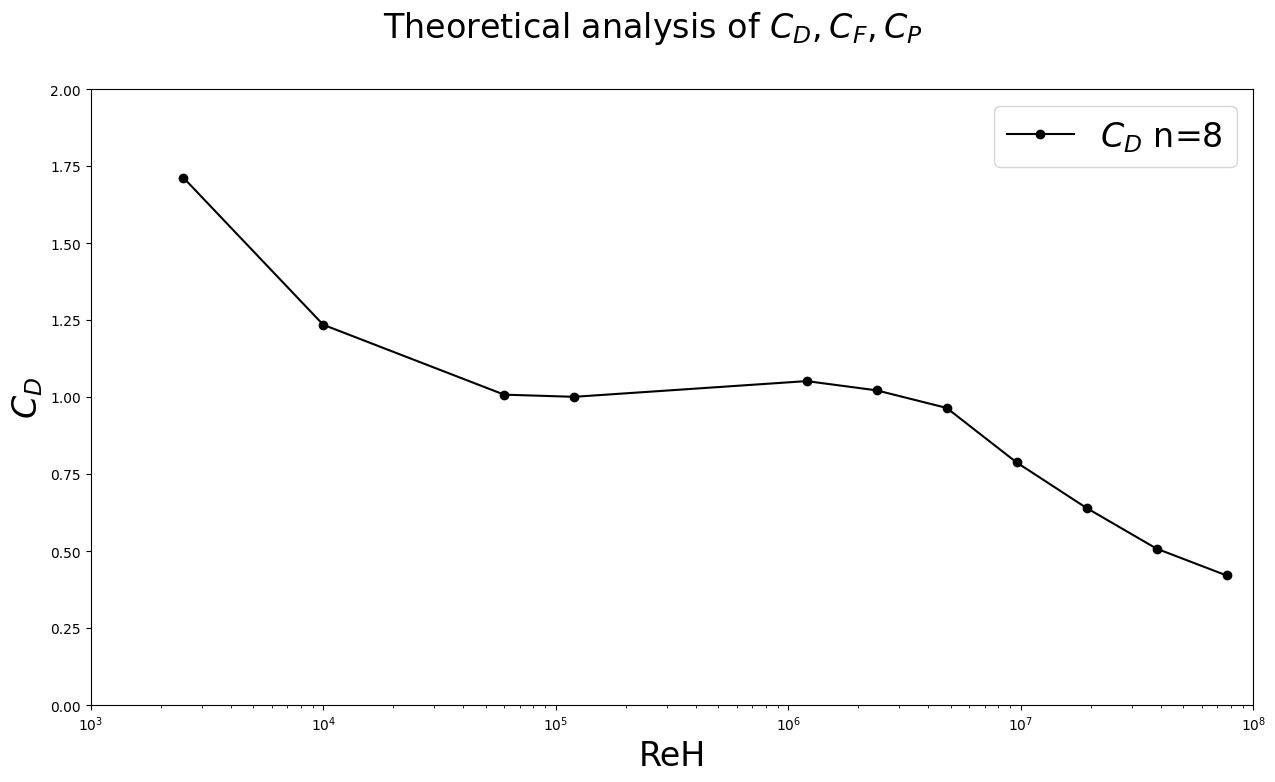

In [95]:

if __name__ == "__main__":
      #key = n
      n = int(input("Enter the number of branch(4, 6, 8) :"))
      model = input("Choose the model (basic or improved ?) :")
      if n == 4:
            if model == 'basic':
                  rot = 180
                  with open(f"C:\\Users\\takut\\OneDrive - 東京工業大学大西研究室\\lab_document\\summation_of_cylinder\\angles_pickle\\angles_Basic_n4_rot_{rot}deg.pickle", "rb") as file:
                        alpha3s = pickle.load(file)
                  
                  Ls = {"0": 357.35e-3, 
                        "1": 357.35e-3 * 0.8, 
                        "2": 357.35e-3 * 0.8 ** 2,
                        "3": 357.35e-3 * 0.8 ** 3,}
                  Ds = {"0": 107.15e-3, 
                        "1": 107.15e-3 * 0.707, 
                        "2": 107.15e-3 * 0.707 ** 2,
                        "3": 107.15e-3 * 0.707 ** 3}
                  As = {'10':0.1497,
                        '20':0.1512,
                        '30':0.1483,
                        '40':0.1519,
                        '50':0.1599,
                        '60':0.1645,
                        '70':0.1663,
                        '80':0.1661,
                        '90':0.1639,
                        '100':0.1561,
                        '110':0.1529,
                        '120':0.1456,
                        '130':0.1306,
                        '140':0.1288,
                        '150':0.1394,
                        '160':0.1356,
                        '170':0.1336,
                        '180':0.1396}
                  A = As[f'{rot}']

            elif model == 'improved':
                  with open(f"C:\\Users\\takut\\OneDrive - 東京工業大学大西研究室\\lab_document\\summation_of_cylinder\\angles_pickle\\imp_angles_n4.pickle", "rb") as file:
                        alpha3s = pickle.load(file)
                  Ls = {"0": 496.93e-3, 
                        "1": 496.93e-3 * 0.58, 
                        "2": 496.93e-3 * 0.58 ** 2,
                        "3": 496.93e-3 * 0.58 ** 3}

                  Ds = {"0": [149.08e-3], 
                        "1": [149.08e-3 * (0.55 ** 0.9), 149.08e-3 * (0.45 ** 0.9)], 
                        "2": [149.08e-3 * (0.55 ** 0.9)**2, 149.08e-3 * (0.45 ** 0.9)**2],
                        "3": [149.08e-3 * (0.55 ** 0.9)**3, 149.08e-3 * (0.45 ** 0.9)**3]}

                  A = 0.2104




      elif n == 6:
            if model == 'basic':
                  rot = 180
                  with open(f"C:\\Users\\takut\\OneDrive - 東京工業大学大西研究室\\lab_document\\summation_of_cylinder\\angles_pickle\\angles_Basic_n6_rot_{rot}deg.pickle", "rb") as file:
                        alpha3s = pickle.load(file)
                  
                  Ls = {"0": 288.94e-3, 
                        "1": 288.94e-3 * 0.8, 
                        "2": 288.94e-3 * 0.8 ** 2,
                        "3": 288.94e-3 * 0.8 ** 3,
                        "4": 288.94e-3 * 0.8 ** 4,
                        "5": 288.94e-3 * 0.8 ** 5}
                  Ds = {"0": 86.64e-3, 
                        "1": 86.64e-3 * 0.707, 
                        "2": 86.64e-3 * 0.707 ** 2,
                        "3": 86.64e-3 * 0.707 ** 3,
                        "4": 86.64e-3 * 0.707 ** 4,
                        "5": 86.64e-3 * 0.707 ** 5}
                  As = {'10':0.1584,
                        '20':0.1574,
                        '30':0.1556,
                        '40':0.1596,
                        '50':0.1658,
                        '60':0.1673,
                        '70':0.1638,
                        '80':0.1601,
                        '90':0.1571,
                        '100':0.1599,
                        '110':0.1523,
                        '120':0.1452,
                        '130':0.1399,
                        '140':0.1439,
                        '150':0.1448,
                        '160':0.1449,
                        '170':0.1487,
                        '180':0.1524}
                  A = As[f'{rot}']
                  #error of  area due to mesh size is approximately 0.07%.
            elif model == 'improved':
                  with open(f"C:\\Users\\takut\\OneDrive - 東京工業大学大西研究室\\lab_document\\summation_of_cylinder\\angles_pickle\\imp_angles_n6.pickle", "rb") as file:
                        alpha3s = pickle.load(file)
                  Ls = {"0": 458.97e-3, 
                        "1": 458.97e-3 * 0.58, 
                        "2": 458.97e-3 * 0.58 ** 2,
                        "3": 458.97e-3 * 0.58 ** 3,
                        "4": 458.97e-3 * 0.58 ** 4,
                        "5": 458.97e-3 * 0.58 ** 5}

                  Ds = {"0": [136.34e-3], 
                        "1": [136.34e-3 * (0.55 ** 0.9), 136.34e-3 * (0.45 ** 0.9)], 
                        "2": [136.34e-3 * (0.55 ** 0.9)**2, 136.34e-3 * (0.45 ** 0.9)**2],
                        "3": [136.34e-3 * (0.55 ** 0.9)**3, 136.34e-3 * (0.45 ** 0.9)**3],
                        "4": [136.34e-3 * (0.55 ** 0.9)**4, 136.34e-3 * (0.45 ** 0.9)**4],
                        "5": [136.34e-3 * (0.55 ** 0.9)**5, 136.34e-3 * (0.45 ** 0.9)**5]}

                  A = 0.2519

      elif n == 8:
            if model == 'basic':
                  rot = 180
                  with open(f"C:\\Users\\takut\\OneDrive - 東京工業大学大西研究室\\lab_document\\summation_of_cylinder\\angles_pickle\\angles_Basic_n8_rot_{rot}deg.pickle", "rb") as file:
                        alpha3s = pickle.load(file)
                  
                  Ls = {"0": 257.32e-3, 
                        "1": 257.32e-3 * 0.8, 
                        "2": 257.32e-3 * 0.8 ** 2,
                        "3": 257.32e-3 * 0.8 ** 3,
                        "4": 257.32e-3 * 0.8 ** 4,
                        "5": 257.32e-3 * 0.8 ** 5,
                        "6": 257.32e-3 * 0.8 ** 6,
                        "7": 257.32e-3 * 0.8 ** 7}
                  Ds = {"0": 77.16e-3, 
                        "1": 77.16e-3 * 0.707, 
                        "2": 77.16e-3 * 0.707 ** 2,
                        "3": 77.16e-3 * 0.707 ** 3,
                        "4": 77.16e-3 * 0.707 ** 4,
                        "5": 77.16e-3 * 0.707 ** 5,
                        "6": 77.16e-3 * 0.707 ** 6,
                        "7": 77.16e-3 * 0.707 ** 7}
                  As = {'10':0.1812,
                        '20':0.1788,
                        '30':0.1784,
                        '40':0.1816,
                        '50':0.1918,
                        '60':0.1894,
                        '70':0.1861,
                        '80':0.1842,
                        '90':0.1839,
                        '100':0.1863,
                        '110':0.1762,
                        '120':0.1683,
                        '130':0.1637,
                        '140':0.1663,
                        '150':0.1644,
                        '160':0.1648,
                        '170':0.1649,
                        '180':0.1749}
                  A = As[f'{rot}']
                  #error of  area due to mesh size is approximately 0.17%.
      #      elif model == 'improved':
      #            with open(f"C:\\Users\\takut\\OneDrive - 東京工業大学大西研究室#\\lab_document\\summation_of_cylinder\\angles_pickle\\imp_angles_n8.pickle", #"rb") as file:
      #                  alpha3s = pickle.load(file)
      #            Ls = {"0": , 
      #                  "1": , 
      #                  "2":  ** 2,
      #                  "3":  ** 3,
      #                  "4":  ** 4,
      #                  "5":  ** 5,
      #                  "6":  ** 6,
      #                  "7":  ** 7}
#
      #            Ds = {"0": , 
      #                  "1": , 
      #                  "2": ,
      #                  "3": ,
      #                  "4": ,
      #                  "5": ,
      #                  "6": ,
      #                  "7": }
#
      #            A = 0
      Uxs = {2500: 0.0378,
             10000: 0.1512,
             60000: 0.9072,
             120000: 1.8144,
             1200000: 18.144,
             2400000: 1.8144*20,
             4800000: 1.8144*40,
             9600000: 1.8144*80,
             19200000: 1.8144*160,
             38400000: 1.8144*320,
             76800000: 1.8144*640}
      print('alphas :', alpha3s)
      main(Uxs, alpha3s, Ls, Ds, A)
      print('lateral area :', total_lateral_area(Ls, Ds))
      print('aspect ratio :', aspect_ratio(Ls, Ds))
      visualization(CD_Trees, CF_Trees, CP_Trees, n)
